In [23]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

diabetes=pd.read_csv('diabetes.txt', sep="\t", header=None, names=['A','B','C','D','E','F','G','H','Diabetes','J'])
print(diabetes.columns)

Index(['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'Diabetes', 'J'], dtype='object')


In [24]:
diabetes.head()

,A,B,C,D,E,F,G,H,Diabetes,J
1,0.176471,0.605,0.426230,0.00,0.000000,0.536513,0.020922,0.066667,1,0
1,0.352941,0.720,0.590164,0.27,0.269504,0.505216,0.075576,0.316667,0,1
1,0.117647,0.875,0.721311,0.00,0.000000,0.341282,0.105892,0.016667,0,1
1,0.705882,0.605,0.639344,0.17,0.000000,0.394933,0.077284,0.683333,0,1
1,0.117647,0.535,0.606557,0.30,0.118203,0.500745,0.139197,0.033333,0,1


In [25]:
print(diabetes.groupby('Diabetes').size())

Diabetes
0    500
1    268
dtype: int64


In [86]:
from sklearn.model_selection import train_test_split
x = diabetes.iloc[:, 0:8].values
y = diabetes.iloc[:, 8].values
x_train,x_test,y_train,y_test=train_test_split(x,y,test_size = 0.2, random_state=0)

In [209]:
from sklearn.neural_network import MLPClassifier
mlp=MLPClassifier(max_iter=1000,alpha=1,random_state=0)
mlp.fit(x_train,y_train)
 
print("Accuracy on training set:{:.3f}".format(mlp.score(x_train,y_train)))
print("Accuracy on test set:{:.3f}".format(mlp.score(x_test,y_test)))

Accuracy on training set:0.759
Accuracy on test set:0.760


In [51]:
import keras
from keras.models import Sequential
from keras.layers import Dense

In [280]:
classifier = Sequential()
classifier.add(Dense(units = 8, kernel_initializer = 'uniform', activation = 'relu', input_dim = 8))
classifier.add(Dense(units = 8, kernel_initializer = 'uniform', activation = 'relu'))
classifier.add(Dense(units = 1, kernel_initializer = 'uniform', activation = 'sigmoid'))
classifier.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])
annHistory = classifier.fit(x_train,y_train, batch_size = 10, epochs = 100)

In [284]:
y_pred = classifier.predict(x_test)
y_pred = (y_pred > 0.5)

print(accuracy_score(y_pred, y_test))

from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, y_pred)

0.7532467532467533


In [267]:
from sklearn.metrics import accuracy_score
import random
from random import randint

def init_population(size):
    activation = ['softmax', 'sigmoid', 'relu']
    optimizer = ['adam','sgd']
    pop =  np.array([[random.choice(activation), random.choice(optimizer), randint(2,20),randint(2,20)]])
    for i in range(0, size):
        pop = np.append(pop, [[random.choice(activation), random.choice(optimizer), randint(2,20),randint(2,20)]], axis=0)
    return pop

def crossover(parent_1, parent_2):
    child = [parent_1[0], parent_2[1], parent_1[2], parent_2[3]]    
    return child

def mutation(child, prob_mut):
    activation = ['softmax', 'sigmoid', 'relu']
    optimizer = ['adam','sgd']
    child_ = np.copy(child)
    for c in range(0, len(child_)):
        prob = np.random.choice(a=2,size=1,p=[prob_mut,1-prob_mut])
        if prob[0] == 0:
            k = randint(0,3)
            if k == 0:
                child_[c,k] = random.choice(activation)
            elif k == 1:
                child_[c,k] = random.choice(optimizer)
            else:
                child_[c,k] = int(child_[c,k]) + randint(1, 4)
    return child_

def fitness_function(pop, x_train, y_train, x_test, y_test): 
    fitness = []
    for w in pop:
        gAclassifier = Sequential()
        gAclassifier.add(Dense(units = int(w[2]), kernel_initializer = 'uniform', activation = str(w[0]), input_dim = 8))
        gAclassifier.add(Dense(units = int(w[3]), kernel_initializer = 'uniform', activation = str(w[0])))
        gAclassifier.add(Dense(units = 1, kernel_initializer = 'uniform', activation = w[0]))
        gAclassifier.compile(optimizer = w[1], loss = 'binary_crossentropy', metrics = ['accuracy'])
        gaHistory = gAclassifier.fit(x_train,y_train, batch_size = 10, epochs = 10)
        y_pred = gAclassifier.predict(x_test)
        y_pred = (y_pred > 0.5)
        f = accuracy_score(y_pred, y_test)
        fitness.append([f, gAclassifier, w, gaHistory])
    return fitness


def ag(X_train, y_train, X_test, y_test, num_epochs, size, prob_mut):
    pop = init_population(size)
    fitness = fitness_function(pop, X_train, y_train, X_test, y_test)
    pop_fitness_sort = np.array(list(reversed(sorted(fitness,key=lambda x: x[0]))))
    
    for i in range(0, num_epochs):
        print ("Number of AG "+ str(i))
        length = len(pop_fitness_sort)
        #seleciona os pais
        parent_1 = pop_fitness_sort[:,2][:length//2]
        parent_2 = pop_fitness_sort[:,2][length//2:]
        #cruzamento
        child_1 = [crossover(parent_1[j], parent_2[j]) for j in range(0, np.min([len(parent_2), len(parent_1)]))]
        child_2 = [crossover(parent_2[j], parent_1[j]) for j in range(0, np.min([len(parent_2), len(parent_1)]))]
        child_2 = mutation(child_2, prob_mut)
        
        #calcula o fitness dos filhos para escolher quem vai passar pra próxima geração
        fitness_child_1 = fitness_function(child_1, X_train, y_train, X_test, y_test)
        fitness_child_2 = fitness_function(child_2, X_train, y_train, X_test, y_test)
        
        pop_fitness_sort = np.concatenate((pop_fitness_sort, fitness_child_1, fitness_child_2))
        sort = np.array(list(reversed(sorted(pop_fitness_sort,key=lambda x: x[0]))))
        
        pop_fitness_sort = sort[0:size, :]
        best_individual = sort[0]
        
    return best_individual

ga_result = ag(x_train, y_train, x_test, y_test, 5, 10, 0.8)
print(ga_result)

Epoch 1/10
614/614 [==============================] - 0s 135us/step - loss: 5.3761 - accuracy: 0.6515
Epoch 2/10
614/614 [==============================] - 0s 60us/step - loss: 5.3761 - accuracy: 0.6515
Epoch 3/10
614/614 [==============================] - 0s 55us/step - loss: 5.3761 - accuracy: 0.6515
Epoch 4/10
614/614 [==============================] - 0s 55us/step - loss: 5.3761 - accuracy: 0.6515
Epoch 5/10
614/614 [==============================] - 0s 54us/step - loss: 5.3761 - accuracy: 0.6515
Epoch 6/10
614/614 [==============================] - 0s 54us/step - loss: 5.3761 - accuracy: 0.6515
Epoch 7/10
614/614 [==============================] - 0s 54us/step - loss: 5.3761 - accuracy: 0.6515
Epoch 8/10
614/614 [==============================] - 0s 52us/step - loss: 5.3761 - accuracy: 0.6515
Epoch 9/10
614/614 [==============================] - 0s 54us/step - loss: 5.3761 - accuracy: 0.6515
Epoch 10/10
614/614 [==============================] - 0s 54us/step - loss: 5.3761 - accur

614/614 [==============================] - 0s 194us/step - loss: 0.6755 - accuracy: 0.6515
Epoch 2/10
614/614 [==============================] - 0s 77us/step - loss: 0.6577 - accuracy: 0.6515
Epoch 3/10
614/614 [==============================] - 0s 57us/step - loss: 0.6506 - accuracy: 0.6515
Epoch 4/10
614/614 [==============================] - 0s 57us/step - loss: 0.6477 - accuracy: 0.6515
Epoch 5/10
614/614 [==============================] - 0s 55us/step - loss: 0.6469 - accuracy: 0.6515
Epoch 6/10
614/614 [==============================] - 0s 107us/step - loss: 0.6467 - accuracy: 0.6515
Epoch 7/10
614/614 [==============================] - 0s 114us/step - loss: 0.6467 - accuracy: 0.6515
Epoch 8/10
614/614 [==============================] - 0s 97us/step - loss: 0.6459 - accuracy: 0.6515
Epoch 9/10
614/614 [==============================] - 0s 55us/step - loss: 0.6457 - accuracy: 0.6515
Epoch 10/10
614/614 [==============================] - 0s 55us/step - loss: 0.6457 - accuracy: 0.65

614/614 [==============================] - 0s 192us/step - loss: 0.6888 - accuracy: 0.5570
Epoch 2/10
614/614 [==============================] - 0s 74us/step - loss: 0.6684 - accuracy: 0.6515
Epoch 3/10
614/614 [==============================] - 0s 81us/step - loss: 0.6560 - accuracy: 0.6515
Epoch 4/10
614/614 [==============================] - 0s 125us/step - loss: 0.6499 - accuracy: 0.6515
Epoch 5/10
614/614 [==============================] - 0s 125us/step - loss: 0.6478 - accuracy: 0.6515
Epoch 6/10
614/614 [==============================] - 0s 127us/step - loss: 0.6471 - accuracy: 0.6515
Epoch 7/10
614/614 [==============================] - 0s 120us/step - loss: 0.6465 - accuracy: 0.6515
Epoch 8/10
614/614 [==============================] - 0s 123us/step - loss: 0.6464 - accuracy: 0.6515
Epoch 9/10
614/614 [==============================] - 0s 120us/step - loss: 0.6464 - accuracy: 0.6515
Epoch 10/10
614/614 [==============================] - 0s 122us/step - loss: 0.6461 - accuracy:

614/614 [==============================] - 0s 181us/step - loss: 0.6766 - accuracy: 0.6319
Epoch 2/10
614/614 [==============================] - 0s 70us/step - loss: 0.6536 - accuracy: 0.6515
Epoch 3/10
614/614 [==============================] - 0s 127us/step - loss: 0.6476 - accuracy: 0.6515
Epoch 4/10
614/614 [==============================] - 0s 133us/step - loss: 0.6471 - accuracy: 0.6515
Epoch 5/10
614/614 [==============================] - 0s 138us/step - loss: 0.6466 - accuracy: 0.6515
Epoch 6/10
614/614 [==============================] - 0s 133us/step - loss: 0.6463 - accuracy: 0.6515
Epoch 7/10
614/614 [==============================] - 0s 133us/step - loss: 0.6463 - accuracy: 0.6515
Epoch 8/10
614/614 [==============================] - 0s 136us/step - loss: 0.6460 - accuracy: 0.6515
Epoch 9/10
614/614 [==============================] - 0s 132us/step - loss: 0.6458 - accuracy: 0.6515
Epoch 10/10
614/614 [==============================] - 0s 62us/step - loss: 0.6472 - accuracy:

614/614 [==============================] - 0s 144us/step - loss: 9.9891 - accuracy: 0.3485
Epoch 2/10
614/614 [==============================] - 0s 62us/step - loss: 9.9891 - accuracy: 0.3485
Epoch 3/10
614/614 [==============================] - 0s 55us/step - loss: 9.9891 - accuracy: 0.3485
Epoch 4/10
614/614 [==============================] - 0s 57us/step - loss: 9.9891 - accuracy: 0.3485
Epoch 5/10
614/614 [==============================] - 0s 57us/step - loss: 9.9891 - accuracy: 0.3485
Epoch 6/10
614/614 [==============================] - 0s 57us/step - loss: 9.9891 - accuracy: 0.3485
Epoch 7/10
614/614 [==============================] - 0s 57us/step - loss: 9.9891 - accuracy: 0.3485
Epoch 8/10
614/614 [==============================] - 0s 57us/step - loss: 9.9891 - accuracy: 0.3485
Epoch 9/10
614/614 [==============================] - 0s 57us/step - loss: 9.9891 - accuracy: 0.3485
Epoch 10/10
614/614 [==============================] - 0s 67us/step - loss: 9.9891 - accuracy: 0.3485

614/614 [==============================] - 0s 188us/step - loss: 9.9891 - accuracy: 0.3485
Epoch 2/10
614/614 [==============================] - 0s 76us/step - loss: 9.9891 - accuracy: 0.3485
Epoch 3/10
614/614 [==============================] - 0s 63us/step - loss: 9.9891 - accuracy: 0.3485
Epoch 4/10
614/614 [==============================] - 0s 116us/step - loss: 9.9891 - accuracy: 0.3485
Epoch 5/10
614/614 [==============================] - 0s 81us/step - loss: 9.9891 - accuracy: 0.3485
Epoch 6/10
614/614 [==============================] - 0s 60us/step - loss: 9.9891 - accuracy: 0.3485
Epoch 7/10
614/614 [==============================] - 0s 85us/step - loss: 9.9891 - accuracy: 0.3485
Epoch 8/10
614/614 [==============================] - 0s 63us/step - loss: 9.9891 - accuracy: 0.3485
Epoch 9/10
614/614 [==============================] - 0s 60us/step - loss: 9.9891 - accuracy: 0.3485
Epoch 10/10
614/614 [==============================] - 0s 60us/step - loss: 9.9891 - accuracy: 0.348

614/614 [==============================] - 0s 131us/step - loss: 0.6770 - accuracy: 0.6287
Epoch 2/10
614/614 [==============================] - 0s 55us/step - loss: 0.6560 - accuracy: 0.6515
Epoch 3/10
614/614 [==============================] - 0s 52us/step - loss: 0.6501 - accuracy: 0.6515
Epoch 4/10
614/614 [==============================] - 0s 52us/step - loss: 0.6479 - accuracy: 0.6515
Epoch 5/10
614/614 [==============================] - 0s 54us/step - loss: 0.6472 - accuracy: 0.6515
Epoch 6/10
614/614 [==============================] - 0s 53us/step - loss: 0.6469 - accuracy: 0.6515
Epoch 7/10
614/614 [==============================] - 0s 52us/step - loss: 0.6469 - accuracy: 0.6515
Epoch 8/10
614/614 [==============================] - 0s 116us/step - loss: 0.6470 - accuracy: 0.6515
Epoch 9/10
614/614 [==============================] - 0s 122us/step - loss: 0.6469 - accuracy: 0.6515
Epoch 10/10
614/614 [==============================] - 0s 121us/step - loss: 0.6470 - accuracy: 0.6

614/614 [==============================] - 0s 185us/step - loss: 1.6006 - accuracy: 0.6515
Epoch 2/10
614/614 [==============================] - 0s 115us/step - loss: 1.1537 - accuracy: 0.6515
Epoch 3/10
614/614 [==============================] - 0s 151us/step - loss: 0.7677 - accuracy: 0.6515
Epoch 4/10
614/614 [==============================] - 0s 152us/step - loss: 0.6200 - accuracy: 0.6515
Epoch 5/10
614/614 [==============================] - 0s 152us/step - loss: 0.6097 - accuracy: 0.6515
Epoch 6/10
614/614 [==============================] - 0s 154us/step - loss: 0.6071 - accuracy: 0.6596
Epoch 7/10
614/614 [==============================] - 0s 156us/step - loss: 0.6050 - accuracy: 0.6531
Epoch 8/10
614/614 [==============================] - 0s 154us/step - loss: 0.6026 - accuracy: 0.6694
Epoch 9/10
614/614 [==============================] - 0s 155us/step - loss: 0.5999 - accuracy: 0.6612
Epoch 10/10
614/614 [==============================] - 0s 152us/step - loss: 0.5978 - accurac

614/614 [==============================] - 0s 204us/step - loss: 0.6656 - accuracy: 0.6515
Epoch 2/10
614/614 [==============================] - 0s 72us/step - loss: 0.6488 - accuracy: 0.6515
Epoch 3/10
614/614 [==============================] - 0s 60us/step - loss: 0.6477 - accuracy: 0.6515
Epoch 4/10
614/614 [==============================] - 0s 57us/step - loss: 0.6470 - accuracy: 0.6515
Epoch 5/10
614/614 [==============================] - 0s 55us/step - loss: 0.6469 - accuracy: 0.6515
Epoch 6/10
614/614 [==============================] - 0s 58us/step - loss: 0.6466 - accuracy: 0.6515
Epoch 7/10
614/614 [==============================] - 0s 57us/step - loss: 0.6473 - accuracy: 0.6515
Epoch 8/10
614/614 [==============================] - 0s 57us/step - loss: 0.6462 - accuracy: 0.6515
Epoch 9/10
614/614 [==============================] - 0s 56us/step - loss: 0.6461 - accuracy: 0.6515
Epoch 10/10
614/614 [==============================] - 0s 55us/step - loss: 0.6459 - accuracy: 0.6515

614/614 [==============================] - 0s 55us/step - loss: 0.6586 - accuracy: 0.6515
Epoch 3/10
614/614 [==============================] - 0s 54us/step - loss: 0.6511 - accuracy: 0.6515
Epoch 4/10
614/614 [==============================] - 0s 54us/step - loss: 0.6485 - accuracy: 0.6515
Epoch 5/10
614/614 [==============================] - 0s 52us/step - loss: 0.6476 - accuracy: 0.6515
Epoch 6/10
614/614 [==============================] - 0s 52us/step - loss: 0.6472 - accuracy: 0.6515
Epoch 7/10
614/614 [==============================] - 0s 54us/step - loss: 0.6471 - accuracy: 0.6515
Epoch 8/10
614/614 [==============================] - 0s 55us/step - loss: 0.6471 - accuracy: 0.6515
Epoch 9/10
614/614 [==============================] - 0s 54us/step - loss: 0.6470 - accuracy: 0.6515
Epoch 10/10
614/614 [==============================] - 0s 52us/step - loss: 0.6468 - accuracy: 0.6515
Epoch 1/10
614/614 [==============================] - 0s 191us/step - loss: 0.6706 - accuracy: 0.6515

Epoch 3/10
614/614 [==============================] - 0s 50us/step - loss: 0.6483 - accuracy: 0.6515
Epoch 4/10
614/614 [==============================] - 0s 52us/step - loss: 0.6473 - accuracy: 0.6515
Epoch 5/10
614/614 [==============================] - 0s 54us/step - loss: 0.6469 - accuracy: 0.6515
Epoch 6/10
614/614 [==============================] - 0s 50us/step - loss: 0.6471 - accuracy: 0.6515
Epoch 7/10
614/614 [==============================] - 0s 53us/step - loss: 0.6468 - accuracy: 0.6515
Epoch 8/10
614/614 [==============================] - 0s 52us/step - loss: 0.6472 - accuracy: 0.6515
Epoch 9/10
614/614 [==============================] - 0s 52us/step - loss: 0.6470 - accuracy: 0.6515
Epoch 10/10
614/614 [==============================] - 0s 52us/step - loss: 0.6468 - accuracy: 0.6515
Number of AG 3
Epoch 1/10
614/614 [==============================] - 0s 186us/step - loss: 1.5449 - accuracy: 0.6515
Epoch 2/10
614/614 [==============================] - 0s 77us/step - loss:

614/614 [==============================] - 0s 59us/step - loss: 0.6474 - accuracy: 0.6515
Epoch 4/10
614/614 [==============================] - 0s 56us/step - loss: 0.6471 - accuracy: 0.6515
Epoch 5/10
614/614 [==============================] - 0s 57us/step - loss: 0.6468 - accuracy: 0.6515
Epoch 6/10
614/614 [==============================] - 0s 57us/step - loss: 0.6465 - accuracy: 0.6515
Epoch 7/10
614/614 [==============================] - 0s 58us/step - loss: 0.6471 - accuracy: 0.6515
Epoch 8/10
614/614 [==============================] - 0s 57us/step - loss: 0.6465 - accuracy: 0.6515
Epoch 9/10
614/614 [==============================] - 0s 58us/step - loss: 0.6463 - accuracy: 0.6515
Epoch 10/10
614/614 [==============================] - 0s 58us/step - loss: 0.6464 - accuracy: 0.6515
Epoch 1/10
614/614 [==============================] - 0s 129us/step - loss: 0.6730 - accuracy: 0.6515
Epoch 2/10
614/614 [==============================] - 0s 54us/step - loss: 0.6575 - accuracy: 0.6515

Epoch 4/10
614/614 [==============================] - 0s 54us/step - loss: 0.6527 - accuracy: 0.6515
Epoch 5/10
614/614 [==============================] - 0s 54us/step - loss: 0.6501 - accuracy: 0.6515
Epoch 6/10
614/614 [==============================] - 0s 54us/step - loss: 0.6486 - accuracy: 0.6515
Epoch 7/10
614/614 [==============================] - 0s 52us/step - loss: 0.6478 - accuracy: 0.6515
Epoch 8/10
614/614 [==============================] - 0s 52us/step - loss: 0.6474 - accuracy: 0.6515
Epoch 9/10
614/614 [==============================] - 0s 54us/step - loss: 0.6471 - accuracy: 0.6515
Epoch 10/10
614/614 [==============================] - 0s 77us/step - loss: 0.6469 - accuracy: 0.6515
Epoch 1/10
614/614 [==============================] - 0s 177us/step - loss: 0.6636 - accuracy: 0.6515
Epoch 2/10
614/614 [==============================] - 0s 66us/step - loss: 0.6493 - accuracy: 0.6515
Epoch 3/10
614/614 [==============================] - 0s 59us/step - loss: 0.6471 - accur

614/614 [==============================] - 0s 59us/step - loss: 0.6467 - accuracy: 0.6515
Epoch 5/10
614/614 [==============================] - 0s 58us/step - loss: 0.6465 - accuracy: 0.6515
Epoch 6/10
614/614 [==============================] - 0s 58us/step - loss: 0.6468 - accuracy: 0.6515
Epoch 7/10
614/614 [==============================] - 0s 57us/step - loss: 0.6465 - accuracy: 0.6515
Epoch 8/10
614/614 [==============================] - 0s 58us/step - loss: 0.6463 - accuracy: 0.6515
Epoch 9/10
614/614 [==============================] - 0s 60us/step - loss: 0.6462 - accuracy: 0.6515
Epoch 10/10
614/614 [==============================] - 0s 58us/step - loss: 0.6461 - accuracy: 0.6515
Epoch 1/10
614/614 [==============================] - 0s 127us/step - loss: 0.6788 - accuracy: 0.6140
Epoch 2/10
614/614 [==============================] - 0s 55us/step - loss: 0.6570 - accuracy: 0.6515
Epoch 3/10
614/614 [==============================] - 0s 50us/step - loss: 0.6506 - accuracy: 0.6515

614/614 [==============================] - 0s 58us/step - loss: 0.6476 - accuracy: 0.6515
Epoch 5/10
614/614 [==============================] - 0s 55us/step - loss: 0.6470 - accuracy: 0.6515
Epoch 6/10
614/614 [==============================] - 0s 55us/step - loss: 0.6466 - accuracy: 0.6515
Epoch 7/10
614/614 [==============================] - 0s 55us/step - loss: 0.6469 - accuracy: 0.6515
Epoch 8/10
614/614 [==============================] - 0s 57us/step - loss: 0.6463 - accuracy: 0.6515
Epoch 9/10
614/614 [==============================] - 0s 57us/step - loss: 0.6467 - accuracy: 0.6515
Epoch 10/10
614/614 [==============================] - 0s 57us/step - loss: 0.6459 - accuracy: 0.6515
Epoch 1/10
614/614 [==============================] - 0s 140us/step - loss: 9.9891 - accuracy: 0.3485
Epoch 2/10
614/614 [==============================] - 0s 61us/step - loss: 9.9891 - accuracy: 0.3485
Epoch 3/10
614/614 [==============================] - 0s 57us/step - loss: 9.9891 - accuracy: 0.3485

614/614 [==============================] - 0s 52us/step - loss: 9.9891 - accuracy: 0.0000e+00
Epoch 5/10
614/614 [==============================] - 0s 122us/step - loss: 9.9891 - accuracy: 0.0000e+00
Epoch 6/10
614/614 [==============================] - 0s 143us/step - loss: 9.9891 - accuracy: 0.0000e+00
Epoch 7/10
614/614 [==============================] - 0s 149us/step - loss: 9.9891 - accuracy: 0.0000e+00
Epoch 8/10
614/614 [==============================] - 0s 146us/step - loss: 9.9891 - accuracy: 0.0000e+00
Epoch 9/10
614/614 [==============================] - 0s 146us/step - loss: 9.9891 - accuracy: 0.0000e+00
Epoch 10/10
614/614 [==============================] - 0s 136us/step - loss: 9.9891 - accuracy: 0.0000e+00
Number of AG 5
Epoch 1/10
614/614 [==============================] - 0s 187us/step - loss: 5.3761 - accuracy: 0.6515
Epoch 2/10
614/614 [==============================] - 0s 75us/step - loss: 5.3761 - accuracy: 0.6515
Epoch 3/10
614/614 [==============================]

614/614 [==============================] - 0s 58us/step - loss: 0.6470 - accuracy: 0.6515
Epoch 4/10
614/614 [==============================] - 0s 57us/step - loss: 0.6468 - accuracy: 0.6515
Epoch 5/10
614/614 [==============================] - 0s 56us/step - loss: 0.6464 - accuracy: 0.6515
Epoch 6/10
614/614 [==============================] - 0s 57us/step - loss: 0.6465 - accuracy: 0.6515
Epoch 7/10
614/614 [==============================] - 0s 55us/step - loss: 0.6462 - accuracy: 0.6515
Epoch 8/10
614/614 [==============================] - 0s 57us/step - loss: 0.6460 - accuracy: 0.6515
Epoch 9/10
614/614 [==============================] - 0s 57us/step - loss: 0.6460 - accuracy: 0.6515
Epoch 10/10
614/614 [==============================] - 0s 57us/step - loss: 0.6457 - accuracy: 0.6515
Epoch 1/10
614/614 [==============================] - 0s 127us/step - loss: 0.6840 - accuracy: 0.5928
Epoch 2/10
614/614 [==============================] - 0s 55us/step - loss: 0.6625 - accuracy: 0.6515

614/614 [==============================] - 0s 57us/step - loss: 0.6483 - accuracy: 0.6515
Epoch 4/10
614/614 [==============================] - 0s 58us/step - loss: 0.6468 - accuracy: 0.6515
Epoch 5/10
614/614 [==============================] - 0s 58us/step - loss: 0.6468 - accuracy: 0.6515
Epoch 6/10
614/614 [==============================] - 0s 58us/step - loss: 0.6464 - accuracy: 0.6515
Epoch 7/10
614/614 [==============================] - 0s 57us/step - loss: 0.6466 - accuracy: 0.6515
Epoch 8/10
614/614 [==============================] - 0s 57us/step - loss: 0.6464 - accuracy: 0.6515
Epoch 9/10
614/614 [==============================] - 0s 58us/step - loss: 0.6462 - accuracy: 0.6515
Epoch 10/10
614/614 [==============================] - 0s 55us/step - loss: 0.6460 - accuracy: 0.6515
Epoch 1/10
614/614 [==============================] - 0s 181us/step - loss: 0.6726 - accuracy: 0.6515
Epoch 2/10
614/614 [==============================] - 0s 72us/step - loss: 0.6522 - accuracy: 0.6515

614/614 [==============================] - 0s 128us/step - loss: 0.9495 - accuracy: 0.6515
Epoch 4/10
614/614 [==============================] - 0s 146us/step - loss: 0.7716 - accuracy: 0.6515
Epoch 5/10
614/614 [==============================] - 0s 146us/step - loss: 0.6796 - accuracy: 0.6515
Epoch 6/10
614/614 [==============================] - 0s 209us/step - loss: 0.6397 - accuracy: 0.6515
Epoch 7/10
614/614 [==============================] - 0s 202us/step - loss: 0.6255 - accuracy: 0.6515
Epoch 8/10
614/614 [==============================] - 0s 186us/step - loss: 0.6210 - accuracy: 0.6547
Epoch 9/10
614/614 [==============================] - 0s 234us/step - loss: 0.6193 - accuracy: 0.6612
Epoch 10/10
614/614 [==============================] - 0s 239us/step - loss: 0.6175 - accuracy: 0.6612
Epoch 1/10
614/614 [==============================] - 0s 182us/step - loss: 1.7266 - accuracy: 0.6515
Epoch 2/10
614/614 [==============================] - 0s 68us/step - loss: 1.3455 - accuracy

614/614 [==============================] - 0s 60us/step - loss: 0.6473 - accuracy: 0.6515
Epoch 4/10
614/614 [==============================] - 0s 55us/step - loss: 0.6471 - accuracy: 0.6515
Epoch 5/10
614/614 [==============================] - 0s 96us/step - loss: 0.6473 - accuracy: 0.6515
Epoch 6/10
614/614 [==============================] - 0s 112us/step - loss: 0.6465 - accuracy: 0.6515
Epoch 7/10
614/614 [==============================] - 0s 113us/step - loss: 0.6460 - accuracy: 0.6515
Epoch 8/10
614/614 [==============================] - 0s 120us/step - loss: 0.6462 - accuracy: 0.6515
Epoch 9/10
614/614 [==============================] - 0s 119us/step - loss: 0.6458 - accuracy: 0.6515
Epoch 10/10
614/614 [==============================] - 0s 119us/step - loss: 0.6460 - accuracy: 0.6515
Epoch 1/10
614/614 [==============================] - 0s 130us/step - loss: 0.6688 - accuracy: 0.6515
Epoch 2/10
614/614 [==============================] - 0s 53us/step - loss: 0.6524 - accuracy: 0

614/614 [==============================] - 0s 52us/step - loss: 0.6530 - accuracy: 0.6515
Epoch 4/10
614/614 [==============================] - 0s 52us/step - loss: 0.6495 - accuracy: 0.6515
Epoch 5/10
614/614 [==============================] - 0s 52us/step - loss: 0.6482 - accuracy: 0.6515
Epoch 6/10
614/614 [==============================] - 0s 52us/step - loss: 0.6475 - accuracy: 0.6515
Epoch 7/10
614/614 [==============================] - 0s 54us/step - loss: 0.6471 - accuracy: 0.6515
Epoch 8/10
614/614 [==============================] - 0s 52us/step - loss: 0.6469 - accuracy: 0.6515
Epoch 9/10
614/614 [==============================] - 0s 54us/step - loss: 0.6468 - accuracy: 0.6515
Epoch 10/10
614/614 [==============================] - 0s 54us/step - loss: 0.6468 - accuracy: 0.6515
Number of AG 7
Epoch 1/10
614/614 [==============================] - 0s 135us/step - loss: 9.7858 - accuracy: 0.0228
Epoch 2/10
614/614 [==============================] - 0s 57us/step - loss: 9.9891 - a

614/614 [==============================] - 0s 59us/step - loss: 9.9891 - accuracy: 0.0000e+00
Epoch 3/10
614/614 [==============================] - 0s 54us/step - loss: 9.9891 - accuracy: 0.0000e+00
Epoch 4/10
614/614 [==============================] - 0s 70us/step - loss: 9.9891 - accuracy: 0.0000e+00
Epoch 5/10
614/614 [==============================] - 0s 115us/step - loss: 9.9891 - accuracy: 0.0000e+00
Epoch 6/10
614/614 [==============================] - 0s 57us/step - loss: 9.9891 - accuracy: 0.0000e+00
Epoch 7/10
614/614 [==============================] - 0s 52us/step - loss: 9.9891 - accuracy: 0.0000e+00
Epoch 8/10
614/614 [==============================] - 0s 52us/step - loss: 9.9891 - accuracy: 0.0000e+00
Epoch 9/10
614/614 [==============================] - 0s 54us/step - loss: 9.9891 - accuracy: 0.0000e+00
Epoch 10/10
614/614 [==============================] - 0s 54us/step - loss: 9.9891 - accuracy: 0.0000e+00
Epoch 1/10
614/614 [==============================] - 0s 181us/s

614/614 [==============================] - 0s 70us/step - loss: 0.6555 - accuracy: 0.6515
Epoch 3/10
614/614 [==============================] - 0s 59us/step - loss: 0.6482 - accuracy: 0.6515
Epoch 4/10
614/614 [==============================] - 0s 58us/step - loss: 0.6471 - accuracy: 0.6515
Epoch 5/10
614/614 [==============================] - 0s 57us/step - loss: 0.6467 - accuracy: 0.6515
Epoch 6/10
614/614 [==============================] - 0s 57us/step - loss: 0.6466 - accuracy: 0.6515
Epoch 7/10
614/614 [==============================] - 0s 57us/step - loss: 0.6462 - accuracy: 0.6515
Epoch 8/10
614/614 [==============================] - 0s 57us/step - loss: 0.6462 - accuracy: 0.6515
Epoch 9/10
614/614 [==============================] - 0s 58us/step - loss: 0.6459 - accuracy: 0.6515
Epoch 10/10
614/614 [==============================] - 0s 58us/step - loss: 0.6459 - accuracy: 0.6515
Epoch 1/10
614/614 [==============================] - 0s 190us/step - loss: 0.6653 - accuracy: 0.6515

614/614 [==============================] - 0s 83us/step - loss: 1.0676 - accuracy: 0.6515
Epoch 3/10
614/614 [==============================] - 0s 60us/step - loss: 0.7575 - accuracy: 0.6515
Epoch 4/10
614/614 [==============================] - 0s 58us/step - loss: 0.6417 - accuracy: 0.6515
Epoch 5/10
614/614 [==============================] - 0s 59us/step - loss: 0.6115 - accuracy: 0.6515
Epoch 6/10
614/614 [==============================] - 0s 58us/step - loss: 0.6061 - accuracy: 0.6547
Epoch 7/10
614/614 [==============================] - 0s 58us/step - loss: 0.6042 - accuracy: 0.6531
Epoch 8/10
614/614 [==============================] - 0s 59us/step - loss: 0.6022 - accuracy: 0.6612
Epoch 9/10
614/614 [==============================] - 0s 58us/step - loss: 0.6011 - accuracy: 0.6645
Epoch 10/10
614/614 [==============================] - 0s 58us/step - loss: 0.5985 - accuracy: 0.6596
Epoch 1/10
614/614 [==============================] - 0s 182us/step - loss: 5.3761 - accuracy: 0.6515

614/614 [==============================] - 0s 55us/step - loss: 9.9891 - accuracy: 0.0000e+00
Epoch 3/10
614/614 [==============================] - 0s 52us/step - loss: 9.9891 - accuracy: 0.0000e+00
Epoch 4/10
614/614 [==============================] - 0s 81us/step - loss: 9.9891 - accuracy: 0.0000e+00
Epoch 5/10
614/614 [==============================] - 0s 149us/step - loss: 9.9891 - accuracy: 0.0000e+00
Epoch 6/10
614/614 [==============================] - 0s 100us/step - loss: 9.9891 - accuracy: 0.0000e+00
Epoch 7/10
614/614 [==============================] - 0s 85us/step - loss: 9.9891 - accuracy: 0.0000e+00
Epoch 8/10
614/614 [==============================] - 0s 85us/step - loss: 9.9891 - accuracy: 0.0000e+00
Epoch 9/10
614/614 [==============================] - 0s 60us/step - loss: 9.9891 - accuracy: 0.0000e+00
Epoch 10/10
614/614 [==============================] - 0s 54us/step - loss: 9.9891 - accuracy: 0.0000e+00
Epoch 1/10
614/614 [==============================] - 0s 196us/

614/614 [==============================] - 0s 71us/step - loss: 0.6511 - accuracy: 0.6515
Epoch 3/10
614/614 [==============================] - 0s 60us/step - loss: 0.6477 - accuracy: 0.6515
Epoch 4/10
614/614 [==============================] - 0s 58us/step - loss: 0.6472 - accuracy: 0.6515
Epoch 5/10
614/614 [==============================] - 0s 58us/step - loss: 0.6467 - accuracy: 0.6515
Epoch 6/10
614/614 [==============================] - 0s 58us/step - loss: 0.6468 - accuracy: 0.6515
Epoch 7/10
614/614 [==============================] - 0s 57us/step - loss: 0.6463 - accuracy: 0.6515
Epoch 8/10
614/614 [==============================] - 0s 57us/step - loss: 0.6463 - accuracy: 0.6515
Epoch 9/10
614/614 [==============================] - 0s 57us/step - loss: 0.6462 - accuracy: 0.6515
Epoch 10/10
614/614 [==============================] - 0s 57us/step - loss: 0.6460 - accuracy: 0.6515
Number of AG 9
Epoch 1/10
614/614 [==============================] - 0s 182us/step - loss: 1.7017 - a

614/614 [==============================] - 0s 68us/step - loss: 0.7365 - accuracy: 0.6515
Epoch 3/10
614/614 [==============================] - 0s 59us/step - loss: 0.6107 - accuracy: 0.6531
Epoch 4/10
614/614 [==============================] - 0s 59us/step - loss: 0.6037 - accuracy: 0.6531
Epoch 5/10
614/614 [==============================] - 0s 58us/step - loss: 0.6004 - accuracy: 0.6678
Epoch 6/10
614/614 [==============================] - 0s 59us/step - loss: 0.5968 - accuracy: 0.6645
Epoch 7/10
614/614 [==============================] - 0s 58us/step - loss: 0.5939 - accuracy: 0.6694
Epoch 8/10
614/614 [==============================] - 0s 61us/step - loss: 0.5911 - accuracy: 0.6710
Epoch 9/10
614/614 [==============================] - 0s 59us/step - loss: 0.5879 - accuracy: 0.6808
Epoch 10/10
614/614 [==============================] - 0s 60us/step - loss: 0.5840 - accuracy: 0.6775
Epoch 1/10
614/614 [==============================] - 0s 193us/step - loss: 1.5635 - accuracy: 0.6515

614/614 [==============================] - 0s 68us/step - loss: 1.5246 - accuracy: 0.6515
Epoch 3/10
614/614 [==============================] - 0s 61us/step - loss: 1.1657 - accuracy: 0.6515
Epoch 4/10
614/614 [==============================] - 0s 58us/step - loss: 0.8545 - accuracy: 0.6515
Epoch 5/10
614/614 [==============================] - 0s 60us/step - loss: 0.7014 - accuracy: 0.6515
Epoch 6/10
614/614 [==============================] - 0s 60us/step - loss: 0.6359 - accuracy: 0.6515
Epoch 7/10
614/614 [==============================] - 0s 60us/step - loss: 0.6128 - accuracy: 0.6515
Epoch 8/10
614/614 [==============================] - 0s 60us/step - loss: 0.6061 - accuracy: 0.6564
Epoch 9/10
614/614 [==============================] - 0s 62us/step - loss: 0.6038 - accuracy: 0.6580
Epoch 10/10
614/614 [==============================] - 0s 59us/step - loss: 0.6025 - accuracy: 0.6645
Epoch 1/10
614/614 [==============================] - 0s 184us/step - loss: 1.7272 - accuracy: 0.6515

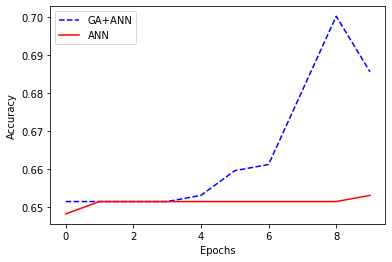

In [279]:
#Accuracy using GA
#ga_model = Sequential()
##ga_model.add(Dense(units = 8, kernel_initializer = 'uniform', activation = melhor_result[2], input_dim = 8))
#ga_model.add(Dense(units = 8, kernel_initializer = 'uniform', activation = melhor_result[0]))
#ga_model.add(Dense(units = 1, kernel_initializer = 'uniform', activation = 'sigmoid'))
#ga_model.compile(optimizer = 'melhor_result[1]', loss = 'binary_crossentropy', metrics = ['accuracy'])
#ga_model.fit(x_train,y_train, batch_size = 10, epochs = 100)
##ga_pred = ga_model.predict(x_test)
#y_pred = (y_pred > 0.5)
#accuracy_GA = accuracy_score(y_pred, y_test)

ann_pred = classifier.predict(x_test)
ann_pred = (ann_pred > 0.5)
accuracy_ANN = accuracy_score(ann_pred, y_test)

gaann_pred = ga_result[1].predict(x_test)
gaann_pred = (gaann_pred > 0.5)
accuracy_GA_ANN = accuracy_score(gaann_pred, y_test)

plt.plot(ga_result[3].history['accuracy'], 'b--', label='GA+ANN')
plt.plot(annHistory.history['accuracy'], 'r', label='ANN')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()